In [21]:
import numpy as np
import pylab as plt
import torch
from tqdm.auto import tqdm
import scipy.linalg
import pandas as pd

from common import gsave, gload
from nde.kernels import load_fmnist_all, KernelPredictor, KernelType

In [2]:
X, Y = load_fmnist_all()
ker = KernelPredictor(X, Y)

In [31]:
I_tr = range(0, 2500)
I_te = range(len(I_tr), len(I_tr)+10000)
preds = ker.predict(I_tr, I_te, ktype=KernelType.GAUSSIAN, sigma=10)
print('acc:', (preds == ker.y[I_te]).mean())

acc: 0.7791


In [14]:
def get_Kte(ktype, sigma):
    I_te = range(60000,70000)
    return ker.d_to_K(ker.D[I_te, :], ktype, sigma)

def train_pair(n, Kte, ktype=KernelType.GAUSSIAN, sigma=0.1):
    '''
        Returns predictions of 2 classifiers trained on random, disjoint subsets of size 'n'.
    '''
    I = np.random.choice(range(60000), n*2, replace=False)
    I_te = range(60000,70000)
    I1, I2 = I[:n], I[n:2*n] # disjoint
    ytrue = ker.y[I_te]
    ypred1 = ker.predict_Kte(I1, Kte[:, I1], ktype, sigma)
    ypred2 = ker.predict_Kte(I2, Kte[:, I2], ktype, sigma)
    return ypred1, ypred2, ytrue

In [35]:
ns = [25, 50, 100, 250, 500, 1000, 2000, 5000, 10000, 25000]
ks = [50, 50, 50, 20, 20, 10, 10, 5, 5, 1]
#ks = [1] * len(ns)

sigma=1.0 #0.1
ktype=KernelType.LAPLACE

Kte = get_Kte(ktype, sigma)

ds = []
for n, k in tqdm(list(zip(ns, ks))):
    for _ in range(k):
        yhat1, yhat2, ytrue = train_pair(n=n, Kte=Kte, ktype=ktype, sigma=sigma)
        d = {'n' : n,
             'sigma': sigma,
             'acc1' : np.mean(yhat1 == ytrue),
             'acc2' : np.mean(yhat2 == ytrue),
             'aggr' : np.mean(yhat1 == yhat2)}
        ds.append(d)
        
df = pd.DataFrame(ds)

In [36]:
#gsave(df, f'gs://ANONYMOUS/results/nde/kernels/fmnist_gauss_s{sigma}')
gsave(df, f'gs://ANONYMOUS/results/nde/kernels/fmnist_lap_s{sigma}')

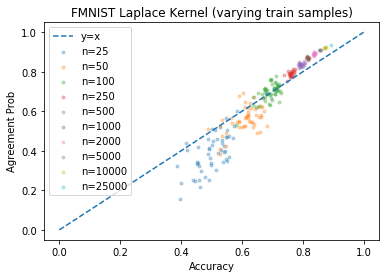

In [37]:
for n in df['n'].unique():
    d = df[df['n'] == n]
    plt.scatter(d['acc1'], d['aggr'], label=f'n={n}', alpha=0.3, marker='.')
    
t = np.linspace(0.0, 1.0, 10)
plt.plot(t, t, '--', label='y=x')
    
plt.legend()
plt.xlabel('Accuracy')
plt.ylabel('Agreement Prob')
plt.title('FMNIST Laplace Kernel (varying train samples)');